# Ex2
New model build up.
 - Load data of image.

/Users/lynch_mini/Documents/SML/5LSL0_MSPD/1A/trained_model_


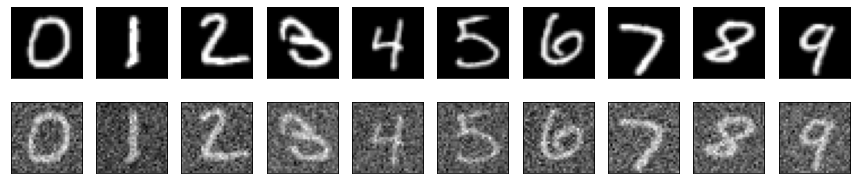

In [2]:
# import packages and file directory
import torch
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader
import os
# pyplot
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.models import LinearAxis, Range1d
import warnings

# for switch cpu if needed
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu" )

# file directory
fileDirectory = os.path.dirname(os.path.abspath('1A'))           # curent file directory 
MODEL__DIR = os.path.join(fileDirectory , "trained_model_") 
print(MODEL__DIR) 

# %% Noisy MNIST dataset
class Noisy_MNIST(Dataset):
    # initialization of the dataset
    def __init__(self, split,data_loc,noise=0.5):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        self.noise    = noise
        
        if self.split == 'train':
            Train = True
        else:
            Train = False
            
        # get the original MNIST dataset   
        Clean_MNIST = datasets.MNIST(self.data_loc, train=Train, download=True)
        
        # reshuffle the test set to have digits 0-9 at the start
        if self.split == 'train':
            data = Clean_MNIST.data.unsqueeze(1)
        else:
            data = Clean_MNIST.data.unsqueeze(1)
            idx = torch.load('test_idx.tar')
            data[:,:] = data[idx,:]
            
        
        # reshape and normalize
        resizer = transforms.Resize(32)
        resized_data = resizer(data)*1.0
        normalized_data = 2 *(resized_data/255) - 1
        
        # create the data
        self.Clean_Images = normalized_data
        self.Noisy_Images = normalized_data + torch.randn(normalized_data.size())*self.noise
        self.Labels       = Clean_MNIST.targets
    
    # return the number of examples in this dataset
    def __len__(self):
        return self.Labels.size(0)
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        clean_image = self.Clean_Images[idx,:,:,:]
        noisy_image = self.Noisy_Images[idx,:,:,:]
        label =  self.Labels[idx]
        
        return clean_image,noisy_image,label
  

# %% dataloader for the Noisy MNIST dataset
def create_dataloaders(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader


if __name__ == "__main__":
    # define parameters
    data_loc = fileDirectory #change the datalocation to something that works for you
    batch_size = 64
    
    # get dataloader
    train_loader, test_loader = create_dataloaders(data_loc, batch_size)
    
    # get some examples
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
    # use these example images througout the assignment as the first 10 correspond to the digits 0-9
    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    # plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
    plt.show()

## New Network strucutre


In [8]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32*32, 32*32) 
        self.fc2 = nn.Linear(32*32, 32*32)
        self.fc3 = nn.Linear(32*32, 32*32)
    def relu(self,x):
        m = x.data
        m[m < 0] = 0 # fancy relu
        x = m.data
        return x
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x) 
        return x

model = Net()
model = model.to(device)
# model = model.cpu() 
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train_set, val_set = torch.utils.data.random_split(train_loader.dataset, [50000, 10000])


## Train model 
Training model

In [9]:
loss_list_train = []
loss_list_validation = []
num_epochs =20

for epoch in range(num_epochs):
    loss_t = 0
    loss_v = 0
    for (x_clean_train, x_noisy_train, labels_train),(x_clean_val, x_noisy_val, labels_val) in zip(train_set,val_set):
        # Transfer to GPU
        x_clean_train = x_clean_train.to(device)
        x_noisy_train = x_noisy_train.to(device)
        labels_train = labels_train.to(device)
        x_clean_val = x_clean_val.to(device)
        x_noisy_val = x_noisy_val.to(device)
        labels_val = labels_val.to(device)
        # Run the forward pass
        outputs_train = model(x_noisy_train)
        outputs_validation = model(x_noisy_val)
        loss_train = criterion(outputs_train, x_clean_train.resize(1024))
        loss_validation = criterion(outputs_validation, x_clean_val.resize(1024))
        loss_t += loss_train.item()
        loss_v += loss_validation.item()

        # Backprop and perform SGD optimisation on training set
        optimizer.zero_grad()
        loss_train.requires_grad_(True)
        loss_train.backward()
        # Perform the SGD optimizer
        optimizer.step()
    
    loss_list_train.append(loss_t)
    loss_list_validation.append(loss_v)
    # Save the model 
    torch.save(model, MODEL__DIR + 'epoch'+ str(epoch+1)+ 'FNN_net_model.ckpt')

# Plot the loss 
p = figure(x_axis_label='Number of epochs',y_axis_label='Train Loss', width=850,x_range = (0,num_epochs), title='Train and validation losses')
p.line(np.arange(len(loss_list_train)), loss_list_train, legend_label="Train Loss")
p.line(np.arange(len(loss_list_validation)), loss_list_validation, legend_label="Validation Loss", color='red')
p.legend.location = "top_right"
show(p)

/Users/lynch_mini/Documents/SML/5LSL0_MSPD/.venv/lib/python3.10/site-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/Users/lynch_mini/Documents/SML/5LSL0_MSPD/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1, 1024])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test model

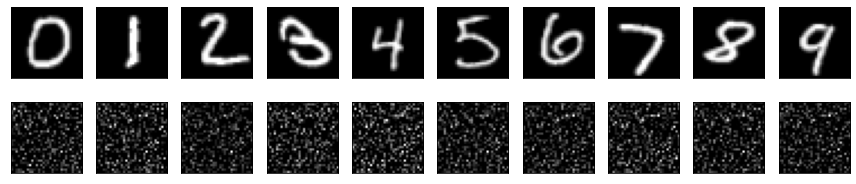

In [10]:
model = torch.load(MODEL__DIR +'epoch'+ str(num_epochs)+ 'FNN_net_model.ckpt')
model.eval()
with torch.no_grad():
    plt.figure(figsize=(12,3))              # show the examples in a plot
    x_noisy_example = x_noisy_example.cpu() # Transfer to GPU
    output = model(x_noisy_example).resize(64,1,32,32).to(device) # resize our output as the same size of input and transfer back to cpu
    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(2,10,i+11)
        plt.imshow(output[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    # plt.savefig("untrained_test_data_examples.png",dpi=300,bbox_inches='tight')
    plt.show()
